In [2]:
import numpy as np,pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten,Dropout,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras import Model
from pathlib import Path
import os.path
import random
from sklearn.model_selection import train_test_split


In [3]:
dataset = "/kaggle/input/bird-speciesss/BIRD_SPECIES"

In [8]:
import os
import pandas as pd
from pathlib import Path

image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath', dtype=str)
labels = pd.Series(labels, name='Label', dtype=str)

# Concatenate filepaths and labels
image_data = pd.concat([filepaths, labels], axis=1)


In [9]:
print(image_data.shape)

(114635, 2)


In [10]:
# Separate in train and test data
train_data, test_data = train_test_split(image_data, test_size=0.2, shuffle=True, random_state=42)

In [11]:
print(train_data.shape,test_data.shape)

(91708, 2) (22927, 2)


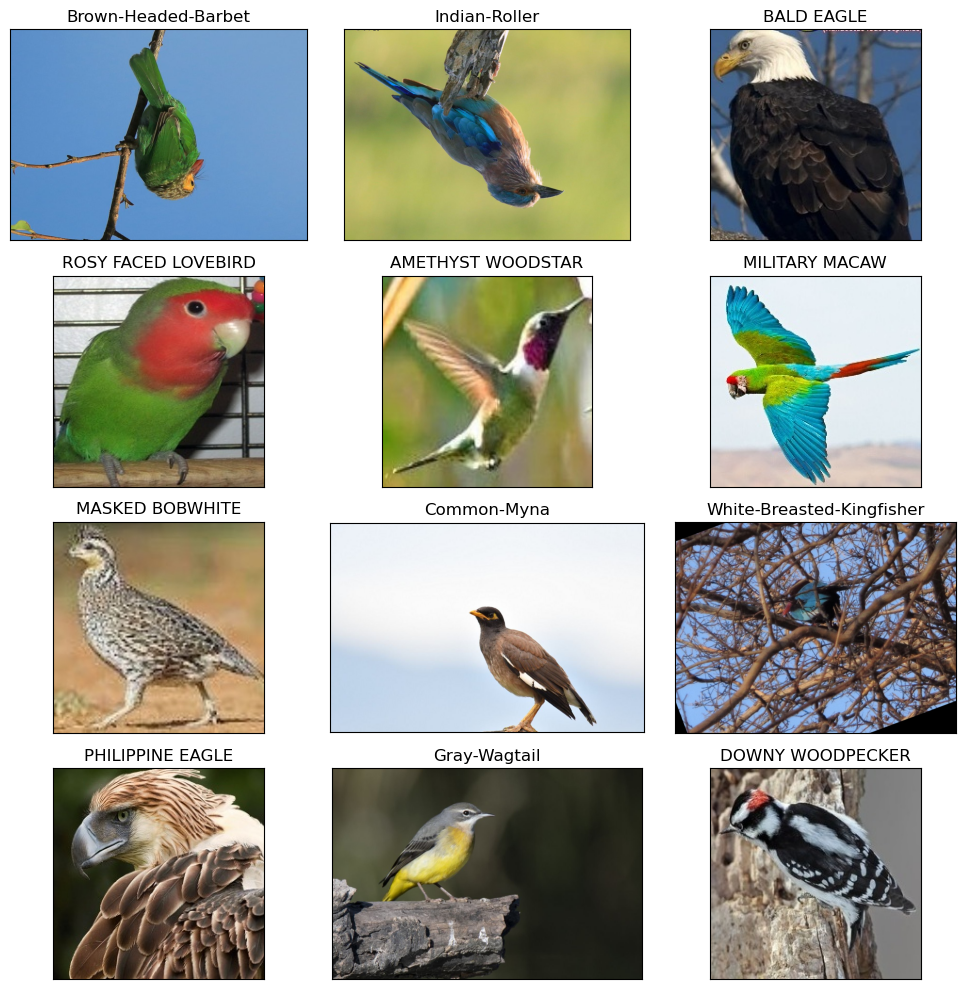

In [12]:
def plot_random_images(image_data, n_images):
    random_index = np.random.randint(0, len(image_data), n_images)
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 10),
                            subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(image_data.Filepath[random_index[i]]))
        ax.set_title(image_data.Label[random_index[i]])

    plt.tight_layout()
    plt.show()

plot_random_images(image_data, 16)


In [14]:

# Import the ResNet-50 model from Keras
from tensorflow.keras.applications import ResNet50

train_generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2
    # there could be image augmentation here
)

# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)


Found 73367 validated image filenames belonging to 550 classes.
Found 18341 validated image filenames belonging to 550 classes.


In [15]:
import json
class_names = train_images.class_indices
listt={}
for k,v in class_names.items():
    listt[v]=k
with open("class_names_name.json", "w") as f:
    json.dump(listt, f, indent=4)
#print(labels)

In [16]:
base_model=tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
    pooling='max',
    classes=550,
)
base_model.trainable = False

94765736/94765736 [==============================] - 4s 0us/step


In [17]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

In [18]:
inputs = base_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(base_model.output)
x = BatchNormalization()(x) # Add batch normalization
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x) # Add batch normalization
x = Dropout(0.3)(x)


outputs = Dense(550, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)


In [19]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [20]:
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10
)


Epoch 1/10
2293/2293 [==============================] - 592s 253ms/step - loss: 4.6822 - accuracy: 0.1931 - val_loss: 3.1403 - val_accuracy: 0.4356
Epoch 2/10
2293/2293 [==============================] - 384s 168ms/step - loss: 2.6824 - accuracy: 0.4692 - val_loss: 1.7434 - val_accuracy: 0.7122
Epoch 3/10
2293/2293 [==============================] - 378s 165ms/step - loss: 1.6921 - accuracy: 0.6513 - val_loss: 1.0803 - val_accuracy: 0.8037
Epoch 4/10
2293/2293 [==============================] - 376s 164ms/step - loss: 1.1829 - accuracy: 0.7411 - val_loss: 0.7700 - val_accuracy: 0.8421
Epoch 5/10
2293/2293 [==============================] - 375s 164ms/step - loss: 0.9160 - accuracy: 0.7880 - val_loss: 0.6325 - val_accuracy: 0.8600
Epoch 6/10
2293/2293 [==============================] - 391s 171ms/step - loss: 0.7495 - accuracy: 0.8189 - val_loss: 0.5579 - val_accuracy: 0.8687
Epoch 7/10
2293/2293 [==============================] - 394s 172ms/step - loss: 0.6471 - accuracy: 0.8384 - val_

In [22]:
test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_data,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 22927 validated image filenames belonging to 550 classes.


In [23]:
print(labels)

0         DALMATIAN PELICAN
1         DALMATIAN PELICAN
2         DALMATIAN PELICAN
3         DALMATIAN PELICAN
4         DALMATIAN PELICAN
                ...        
114630         GOLDEN EAGLE
114631         GOLDEN EAGLE
114632         GOLDEN EAGLE
114633         GOLDEN EAGLE
114634         GOLDEN EAGLE
Name: Label, Length: 114635, dtype: object


In [26]:
test_accuracy= model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(test_accuracy[0]))
print("Test Accuracy: {:.2f}%".format(test_accuracy[1] * 100))

    Test Loss: 0.43795
Test Accuracy: 88.61%


In [27]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((i,j) for j,i in labels.items())
pred = [labels[j] for j in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

717/717 [==============================] - 97s 136ms/step
The first 5 predictions: ['GOLDEN CHLOROPHONIA', 'SHOEBILL', 'BLACK SWAN', 'BARROWS GOLDENEYE', 'MALEO']


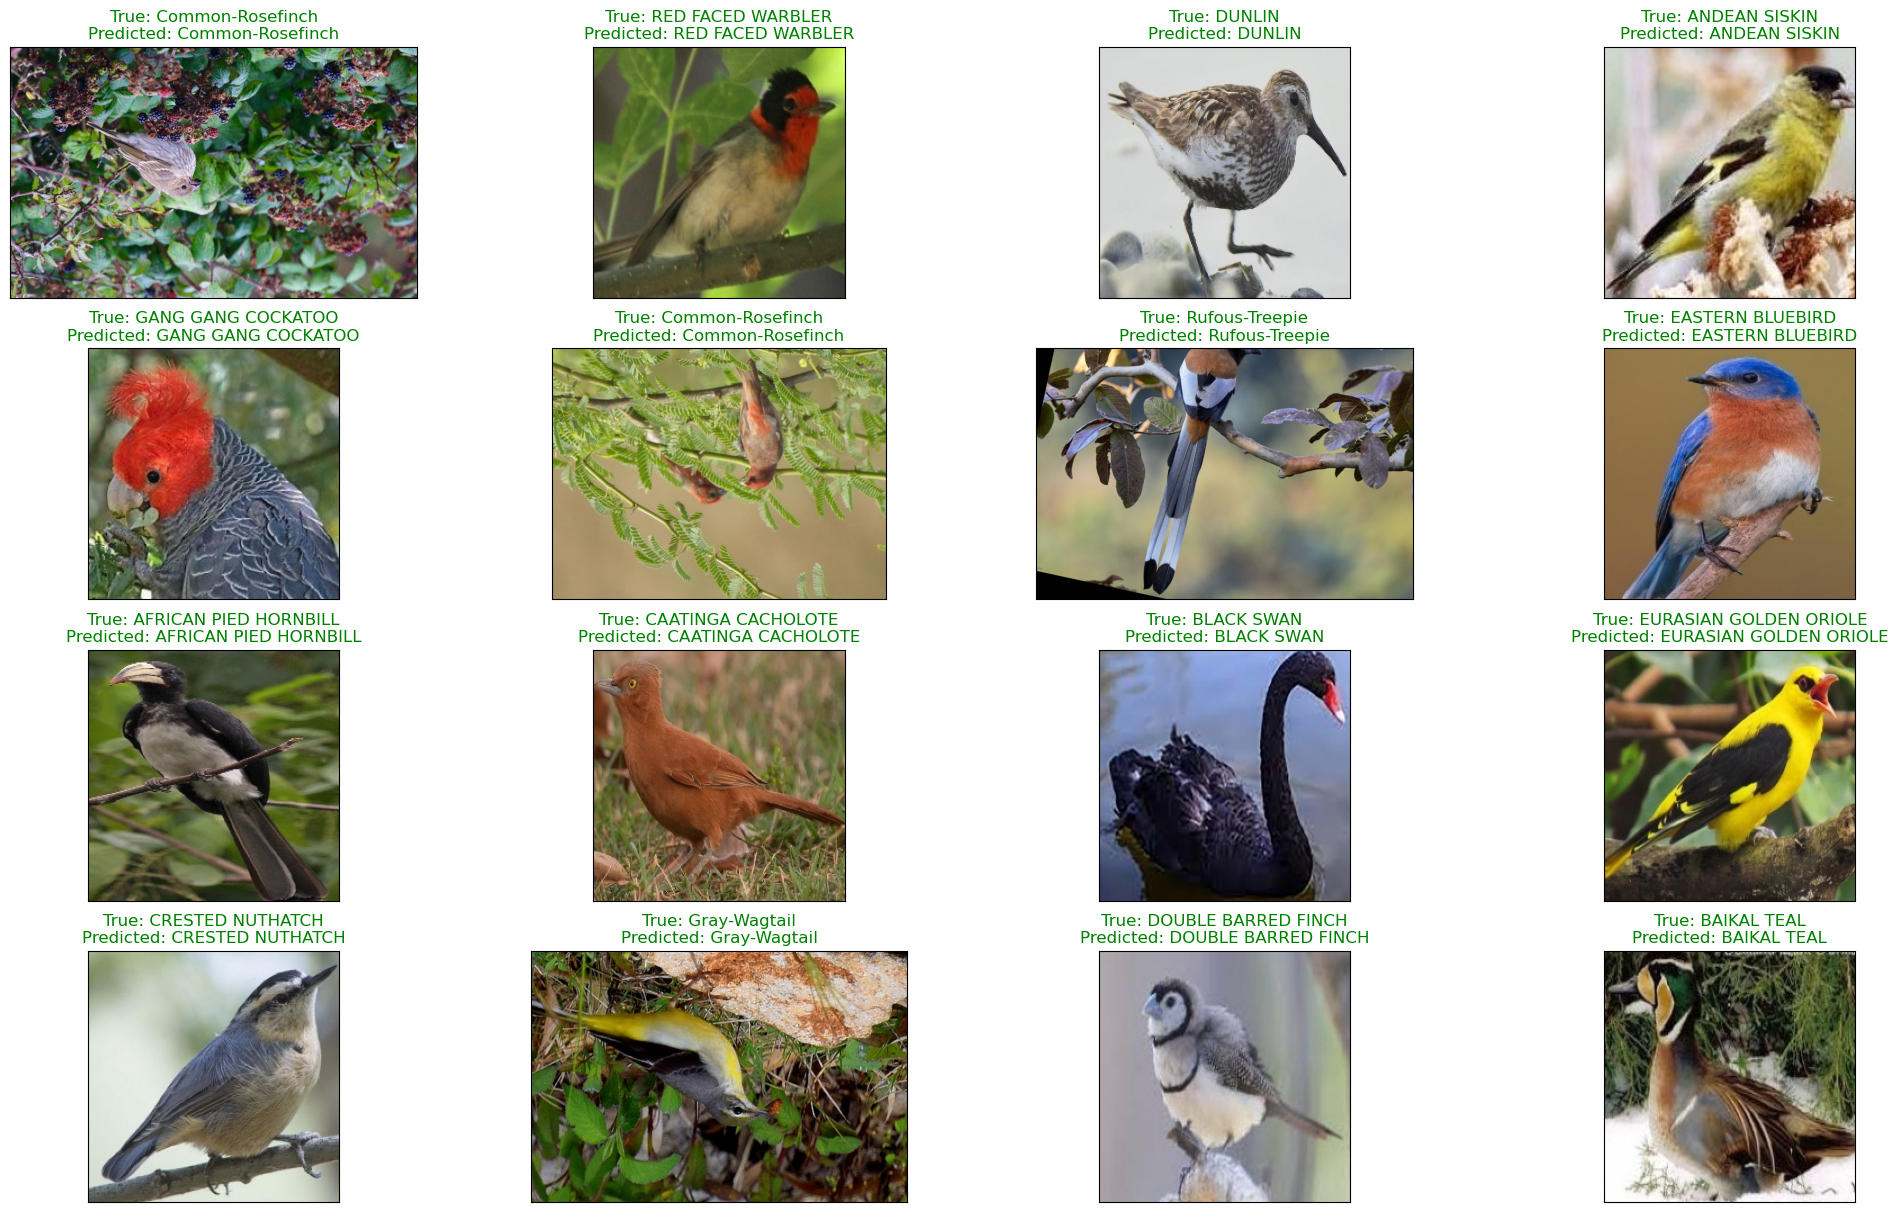

<Figure size 640x480 with 0 Axes>

In [30]:
# random_index = np.random.randint(0, len(test_df) - 1, 30)
# fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(25, 15),
#                         subplot_kw={'xticks': [], 'yticks': []})

# for i, ax in enumerate(axes.flat):
#     ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
#     if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
#         color = "green"
#     else:
#         color = "red"
#     ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
# plt.show()
# plt.tight_layout()


def plot_random_predictions(test_data, pred, n_images):
    random_index = np.random.randint(0, len(test_data) - 1, n_images)
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(25, 15),
                            subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_data.Filepath.iloc[random_index[i]]))
        true_label = test_data.Label.iloc[random_index[i]]
        pred_label = pred[random_index[i]]
        color = "green" if true_label == pred_label else "red"
        ax.set_title(f"True: {true_label}\nPredicted: {pred_label}", color=color)

    plt.show()
    plt.tight_layout()

plot_random_predictions(test_data, pred, 30)


In [31]:
model.save("fine_tune_resnet.h5")
model.save_weights('fine_tune_my_weights_resnet.h5')

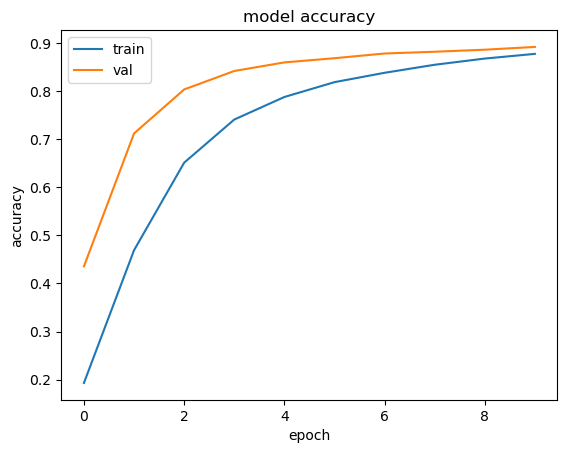

In [32]:
plt.plot(history.history['accuracy']) # plot the training accuracy
plt.plot(history.history['val_accuracy']) # plot the validation accuracy
plt.title('model accuracy') # set the title
plt.ylabel('accuracy') # set the y-axis label
plt.xlabel('epoch') # set the x-axis label
plt.legend(['train', 'val'], loc='upper left') # set the legend
plt.show()

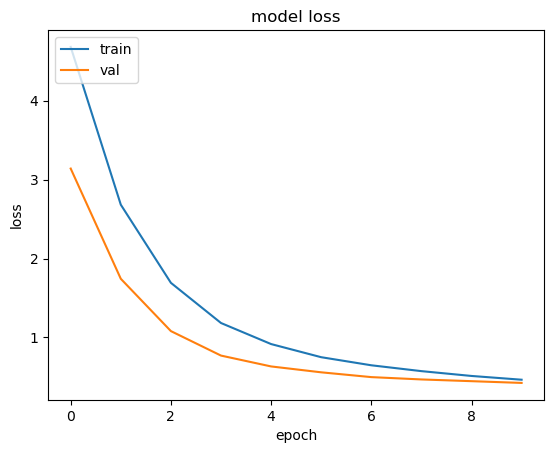

In [33]:
plt.plot(history.history['loss']) # plot the training loss
plt.plot(history.history['val_loss']) # plot the validation loss
plt.title('model loss') # set the title
plt.ylabel('loss') # set the y-axis label
plt.xlabel('epoch') # set the x-axis label
plt.legend(['train', 'val'], loc='upper left') # set the legend
plt.show()